In [1]:
import os
import sys
from os.path import join
import json

# Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import nfl_data_py as nfl
import statsmodels.api as sm

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(ROOT_DIR,'py'))

import util
from plot.plot_simple import plot_play_with_speed

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

with open("paths.json", 'r') as f:
    paths = json.load(f)

PROCESSED_DATA_PATH = paths['processed_data']

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load and Filter the Data

In [2]:
run_concepts = pd.read_pickle(join(PROCESSED_DATA_PATH, 'run_concepts.pkl'))

motion = pd.DataFrame()
for wk in range(1,10):
    motion_tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'motion_plays.pkl'))
    motion = pd.concat([motion, motion_tmp])
motion = motion.reset_index(drop=True)
motion['motion_group'] = motion.motion_group.fillna('DROP')

df = run_concepts.merge(motion, on='game_play_id', how='left')
df['game_id'] = df.game_play_id.apply(lambda x: x.split('_')[0]).astype(int)

games = pd.DataFrame()
for wk in range(1,10):
    game_tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'games.pkl'))
    games = pd.concat([games, game_tmp[['game_id','home_team_abbr']]])
df = df.merge(games, on='game_id', how='left')

df = df[df.motion_group != 'DROP']

df.drop(columns=['game_id'], inplace=True)

df['motion_present'] = ~df.motion_nfl_id.isnull()

del motion_tmp, game_tmp, motion, run_concepts, games

In [3]:
df['motion_towards_playside'] = np.where(
    df.motion_present,
    np.where(
        (df.play_dir_location.isin(['inside-left', 'outside-left']) & (df.motion_dir_last == 'left')) |
        (df.play_dir_location.isin(['inside-right', 'outside-right']) & (df.motion_dir_last == 'right')),
        1,
        np.where(
            df.play_dir_location == 'middle',
            0,
            -1
        ),
    ),
    np.nan
)

drop_cols = ['play_dir', 'motion_nfl_id', 'motion_position',
             'initial_alignment', 'n_direction_changes', 'same_motion_dir',
             'motion_dir_first', 'motion_dir_last', 'motion_sub_group']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

In [4]:
cols = ['game_play_id',
       'down', 'yards_to_go', 
       'possession_team', 'defensive_team', 
       'pre_snap_home_score','pre_snap_visitor_score',
       'absolute_yardline_number', 
       'pre_snap_home_team_win_probability',
       'offense_formation', 'defenders_in_box', 
       'expected_points_added',
       'yards_gained']

df_play = pd.DataFrame()
for wk in range(1, 10):
    tmp = pd.read_pickle(join(PROCESSED_DATA_PATH, f'wk{wk}', 'play_final.pkl'))
    df_play = pd.concat([df_play, tmp[cols]])

df_play = df_play.reset_index(drop=True)

del tmp

In [5]:
df = df.merge(df_play, on='game_play_id', how='left')

In [6]:
# Drop "DRAW" plays as they dont fall into Zone, Gap, or Man concepts
df = df.query('run_concept != "DRAW"').reset_index(drop=True)

df.query('motion_present == 1').value_counts('run_concept')

run_concept
OUTSIDE ZONE    624
INSIDE ZONE     380
MAN             310
POWER           202
PULL LEAD       187
COUNTER         119
TRAP             22
dtype: int64

In [7]:
# Group Trap, Counter, Pull Lead, and Power plays into Gap
df['run_concept'] = np.where(
    df.run_concept.isin(['TRAP', 'COUNTER', 'PULL LEAD', 'POWER']),
    'GAP',
    df.run_concept
)
df.query('motion_present == 1').value_counts('run_concept')

run_concept
OUTSIDE ZONE    624
GAP             530
INSIDE ZONE     380
MAN             310
dtype: int64

In [8]:
(
    df
    .value_counts(['run_concept', 'motion_group'])
    .reset_index().rename(columns={0:'count'})
    .sort_values(['run_concept', 'count'], ascending=[True, False])
)

,run_concept,motion_group,count
1,GAP,Jet,165
5,GAP,Over,104
7,GAP,Orbit,88
9,GAP,Fly,65
10,GAP,Glide,63
17,GAP,Yo-Yo,41
27,GAP,Shuffle,2
28,GAP,In,2
2,INSIDE ZONE,Jet,155
8,INSIDE ZONE,Orbit,77


In [9]:
# Drop Shuffle and In motion plays, as there are too few instances to ensure the distribution is representative
df = df.query('motion_group not in ["Shuffle", "In"]').reset_index(drop=True)

In [10]:
(
    df
    .value_counts(['run_concept', 'motion_group'])
    .reset_index().rename(columns={0:'count'})
    .sort_values(['run_concept', 'count'], ascending=[True, False])
)

,run_concept,motion_group,count
1,GAP,Jet,165
5,GAP,Over,104
7,GAP,Orbit,88
9,GAP,Fly,65
10,GAP,Glide,63
17,GAP,Yo-Yo,41
2,INSIDE ZONE,Jet,155
8,INSIDE ZONE,Orbit,77
13,INSIDE ZONE,Fly,50
19,INSIDE ZONE,Yo-Yo,36


In [11]:
df['pos_team_is_home'] = df.possession_team == df.home_team_abbr
df['pre_snap_score_diff'] = np.where(
    df.pos_team_is_home,
    df.pre_snap_home_score - df.pre_snap_visitor_score,
    df.pre_snap_visitor_score - df.pre_snap_home_score
)
df['pre_snap_wp'] = np.where(
    df.pos_team_is_home,
    df.pre_snap_home_team_win_probability,
    1 - df.pre_snap_home_team_win_probability
)

In [12]:
cols = ['game_play_id', 'run_concept', 'play_dir_location',
       'motion_had_rush_attempt', 'pre_snap_motion_dist_traveled',
       'motion_group', 'motion_present',
       'motion_towards_playside', 'down', 'yards_to_go',
       'absolute_yardline_number',
       'offense_formation', 'defenders_in_box',
       'pre_snap_score_diff','pre_snap_wp',
       'yards_gained'] #'expected_points_added']

df = df[cols]

In [13]:
df.head()

,game_play_id,run_concept,play_dir_location,motion_had_rush_attempt,pre_snap_motion_dist_traveled,motion_group,motion_present,motion_towards_playside,down,yards_to_go,absolute_yardline_number,offense_formation,defenders_in_box,pre_snap_score_diff,pre_snap_wp,yards_gained
0,2022091105_3712,OUTSIDE ZONE,inside-right,NaN,NaN,NaN,False,NaN,1,10,81,SINGLEBACK,6.0,-7,0.221582,14
1,2022091104_1094,OUTSIDE ZONE,outside-right,0.0,0.697350,Jet,True,1.0,1,10,35,SINGLEBACK,7.0,0,0.395236,1
2,2022091101_3923,INSIDE ZONE,middle,NaN,NaN,NaN,False,NaN,2,11,95,SINGLEBACK,8.0,-2,0.741719,0
3,2022091106_1380,INSIDE ZONE,inside-right,0.0,8.234742,Orbit,True,1.0,1,10,18,I_FORM,7.0,10,0.847051,1
4,2022091100_501,OUTSIDE ZONE,outside-left,0.0,9.052830,Orbit,True,1.0,1,10,33,SINGLEBACK,6.0,-3,0.618278,5


# EDA of Relationship Between Variables and Rush Yards Gained

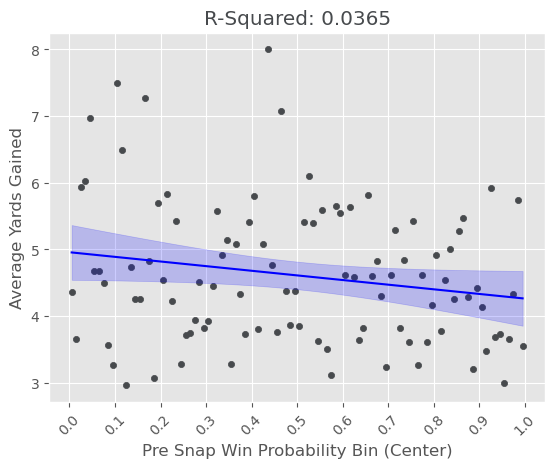

In [14]:
# Bin the win probability by 0.01
df['wp_bin'] = pd.cut(df['pre_snap_wp'], bins=np.arange(0, 1.01, 0.01), include_lowest=True)

# Calculate the average yards gained for each bin
wp_bin_avg = df.groupby('wp_bin').agg({'yards_gained': 'mean'}).reset_index()
wp_bin_avg['bin_center'] = np.arange(0.005, 1.005, 0.01)  # Center of each bin

# Linear regression for best fit line using statsmodels
X = sm.add_constant(wp_bin_avg['bin_center'])  # Add constant for intercept
ols_model = sm.OLS(wp_bin_avg['yards_gained'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Scatter plot for average yards gained per bin
ax.scatter(
    wp_bin_avg['bin_center'], 
    wp_bin_avg['yards_gained'], 
    marker='o', 
    color='#474a4d', 
    s=20, 
    label='Binned Average'
)

# Best fit line
y_pred = est.predict(X)
ax.plot(
    wp_bin_avg['bin_center'], 
    y_pred, 
    color='blue', 
    label='Best Fit Line'
)

# Shaded confidence interval
ax.fill_between(
    wp_bin_avg['bin_center'], 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
    label='95% CI'
)

# Plot customization
plt.xlabel('Pre Snap Win Probability Bin (Center)')
plt.ylabel('Average Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.xticks(ticks=np.arange(0, 1.05, 0.1), rotation=45)
plt.grid(True)
plt.gca().set_axisbelow(True)

df.drop(columns=['wp_bin'], inplace=True)

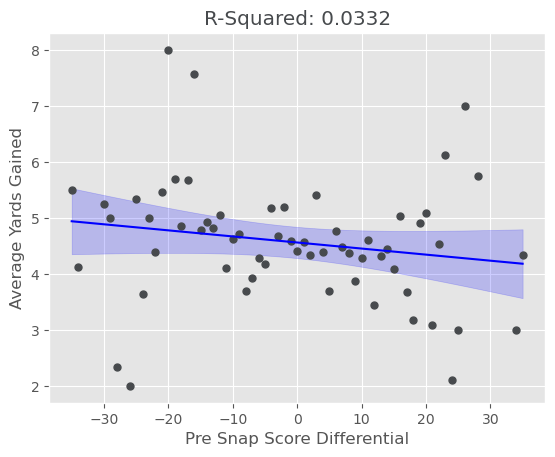

In [15]:
plt.style.use('ggplot')

diff_bin_avg = df.groupby('pre_snap_score_diff').agg({'yards_gained': 'mean'}).reset_index()

# Linear regression for best fit line
X = sm.add_constant(diff_bin_avg['pre_snap_score_diff'])
ols_model = sm.OLS(diff_bin_avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
diff_bin_avg.plot(x='pre_snap_score_diff',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = diff_bin_avg.pre_snap_score_diff.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Pre Snap Score Differential')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

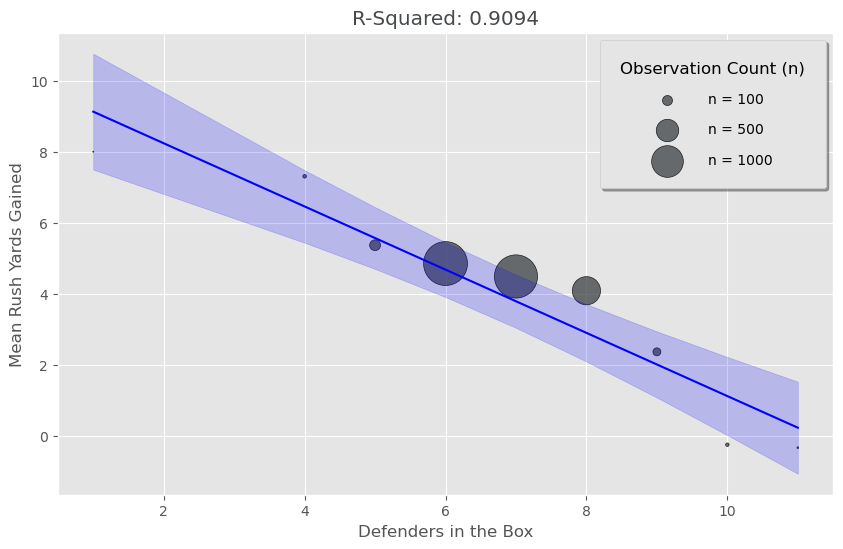

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate the average and count for each group of defenders in the box
avgs = df.groupby('defenders_in_box').agg(
    yards_gained_mean=('yards_gained', 'mean'),
    n=('yards_gained', 'size')
).reset_index()

# Linear regression for best fit line
X = sm.add_constant(avgs['defenders_in_box'])
ols_model = sm.OLS(avgs['yards_gained_mean'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

# Scale marker size based on n (number of observations)
size_scale = 1000  # Adjust for better visualization
marker_sizes = avgs['n'] * size_scale / avgs['n'].max()

# Scatter plot with variable marker sizes
scatter = ax.scatter(
    avgs['defenders_in_box'], 
    avgs['yards_gained_mean'], 
    s=marker_sizes, 
    c='#474a4d', 
    alpha=0.8, 
    edgecolor='black', 
)

# Best fit line
x_pred = avgs['defenders_in_box'].values
y_pred = est.predict(X)
ax.plot(x_pred, y_pred, color='blue')

# Shaded confidence interval
ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
)

# Add a legend for specific values of n
example_ns = [100, 500, 1000]
for example_n in example_ns:
    ax.scatter(
        [], [], 
        s=example_n * size_scale / avgs['n'].max(), 
        c='#474a4d', 
        alpha=0.8, 
        edgecolor='black', 
        label=f"n = {example_n}"
    )

# Customize legend with spacing between lines
legend = plt.legend(
    title='Observation Count (n)', 
    loc='upper right',
    fontsize=10, 
    title_fontsize=12, 
    frameon=True,
    shadow=True,
    handletextpad=2,  # Add spacing between legend text and markers
    borderpad=1.5,    # Add padding around legend box
    labelspacing=1.2  # Add spacing between legend entries
)

# Plot customization
plt.xlabel('Defenders in the Box')
plt.ylabel('Mean Rush Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

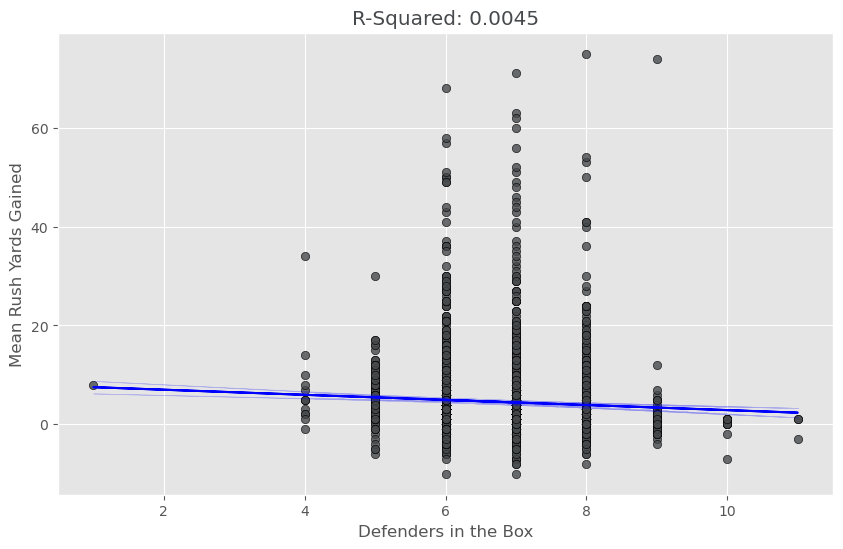

In [17]:
# Linear regression for best fit line
X = sm.add_constant(df['defenders_in_box'])
ols_model = sm.OLS(df['yards_gained'], X)
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with variable marker sizes
scatter = ax.scatter(
    df['defenders_in_box'], 
    df['yards_gained'], 
    c='#474a4d', 
    alpha=0.8, 
    edgecolor='black', 
)

# Best fit line
x_pred = df['defenders_in_box'].values
y_pred = est.predict(X)
ax.plot(x_pred, y_pred, color='blue')

# Shaded confidence interval
ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
)

# Plot customization
plt.xlabel('Defenders in the Box')
plt.ylabel('Mean Rush Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

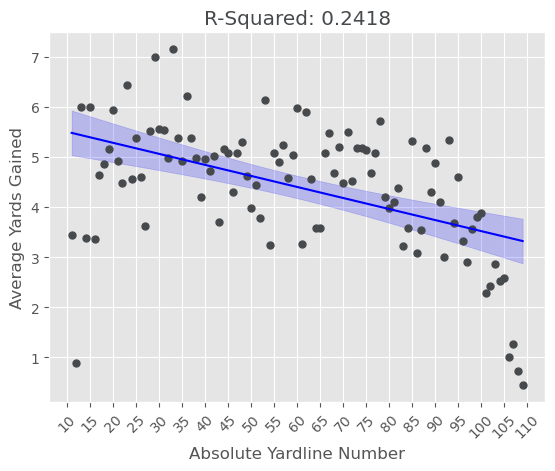

In [18]:
plt.style.use('ggplot')

avg = df.groupby('absolute_yardline_number').agg({'yards_gained': 'mean'}).reset_index()

# Linear regression for best fit line
X = sm.add_constant(avg['absolute_yardline_number'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='absolute_yardline_number',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.absolute_yardline_number.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Absolute Yardline Number')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(ticks=np.arange(10, 111, 5), rotation=45)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

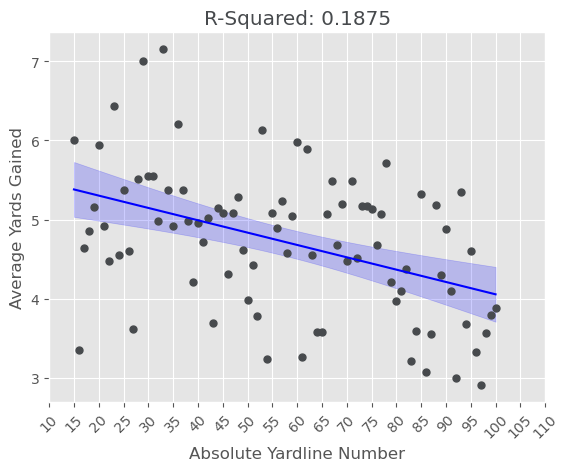

In [19]:
plt.style.use('ggplot')

avg = (
    df
    .query('15 <= absolute_yardline_number <= 100') # filter between 5 and 90 yard lines
    .groupby('absolute_yardline_number')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

# Linear regression for best fit line
X = sm.add_constant(avg['absolute_yardline_number'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='absolute_yardline_number',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.absolute_yardline_number.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Absolute Yardline Number')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(ticks=np.arange(10, 111, 5), rotation=45)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

<Figure size 1200x600 with 0 Axes>

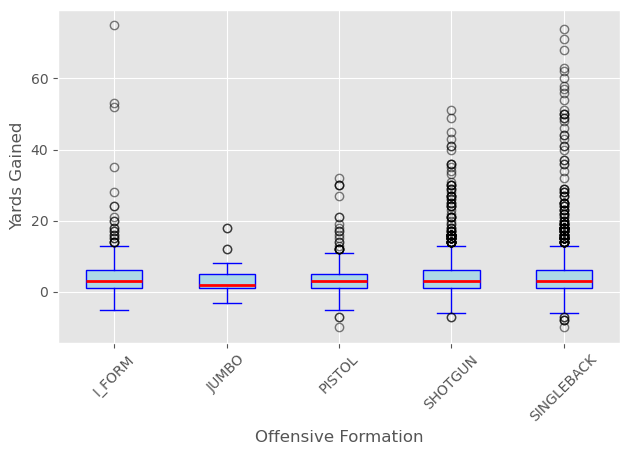

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Generate a boxplot grouped by 'offense_formation' with 'yards_gained' on the y-axis
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='offense_formation',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Offensive Formation')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
df.groupby('offense_formation').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
offense_formation,,
SHOTGUN,4.690068,60.045662
SINGLEBACK,4.551898,57.759031
I_FORM,4.543897,57.372591
PISTOL,3.966463,61.536585
JUMBO,3.542857,65.142857


<Figure size 1200x600 with 0 Axes>

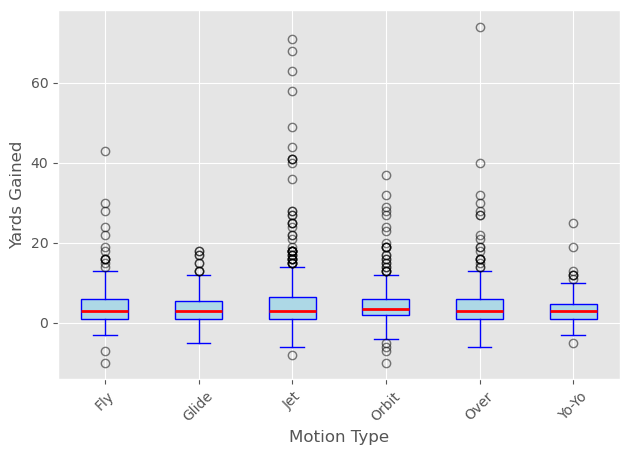

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.query('motion_present').boxplot(
    column='yards_gained',
    by='motion_group',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Motion Type')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
df.groupby('motion_group').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
motion_group,,
Jet,5.092399,57.886736
Orbit,4.586826,57.332335
Over,4.546713,58.775087
Fly,4.420091,58.287671
Glide,3.892216,59.089820
Yo-Yo,3.425373,59.082090


<Figure size 1200x600 with 0 Axes>

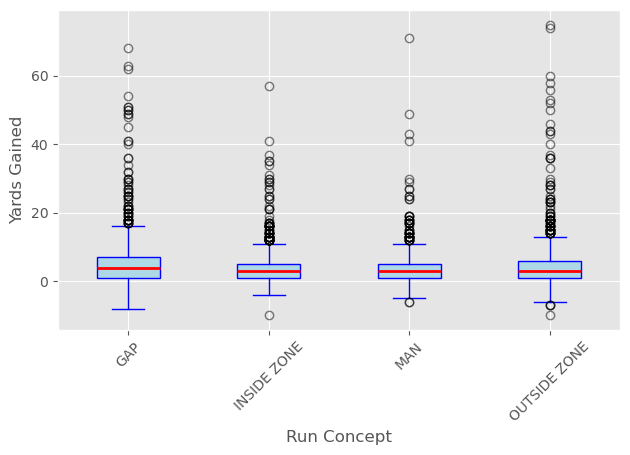

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='run_concept',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Run Concept')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
df.groupby('run_concept').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
run_concept,,
GAP,5.178881,58.764381
OUTSIDE ZONE,4.473369,56.073236
INSIDE ZONE,4.261058,60.422376
MAN,4.159763,61.911243


In [26]:
df.groupby('motion_present').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
motion_present,,
True,4.597574,58.173649
False,4.527580,59.305922


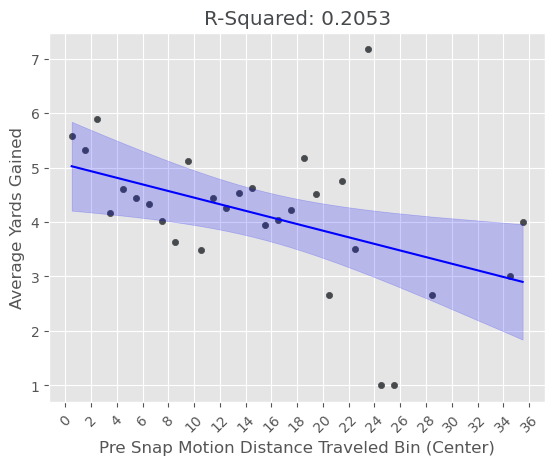

In [27]:
# Bin the win probability by 0.01
df['wp_bin'] = pd.cut(
    df['pre_snap_motion_dist_traveled'], 
    bins=np.arange(
        df['pre_snap_motion_dist_traveled'].min(),
        df['pre_snap_motion_dist_traveled'].max() + 1,
        1
    ),
    include_lowest=True
)

# Calculate the average yards gained for each bin
wp_bin_avg = df.groupby('wp_bin').agg({'yards_gained': 'mean'}).reset_index()
wp_bin_avg['bin_center'] = np.arange(
    df['pre_snap_motion_dist_traveled'].min() + 0.5,
    df['pre_snap_motion_dist_traveled'].max() + 0.5,
    1
)  

# Linear regression for best fit line using statsmodels
X = sm.add_constant(wp_bin_avg['bin_center'])  # Add constant for intercept
ols_model = sm.OLS(wp_bin_avg.loc[~wp_bin_avg['yards_gained'].isna(),'yards_gained'], X[~wp_bin_avg['yards_gained'].isna()])
est = ols_model.fit()

# Generate predictions and confidence intervals
pred = est.get_prediction(X[~wp_bin_avg['yards_gained'].isna()]).summary_frame()

# Plotting
plt.style.use('ggplot')
fig, ax = plt.subplots()

# Scatter plot for average yards gained per bin
ax.scatter(
    wp_bin_avg['bin_center'], 
    wp_bin_avg['yards_gained'], 
    marker='o', 
    color='#474a4d', 
    s=20, 
    label='Binned Average'
)

# Best fit line
y_pred = est.predict(X[~wp_bin_avg['yards_gained'].isna()])
ax.plot(
    wp_bin_avg['bin_center'][~wp_bin_avg['yards_gained'].isna()],
    y_pred, 
    color='blue', 
    label='Best Fit Line'
)

# Shaded confidence interval
ax.fill_between(
    wp_bin_avg.loc[~wp_bin_avg['yards_gained'].isna(),'bin_center'], 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2, 
    label='95% CI'
)

# Plot customization
plt.xlabel('Pre Snap Motion Distance Traveled Bin (Center)')
plt.ylabel('Average Yards Gained')
plt.title(f'R-Squared: {est.rsquared:.4f}', color='#474a4d')
plt.xticks(
    ticks=np.arange(
        df['pre_snap_motion_dist_traveled'].min(),
        df['pre_snap_motion_dist_traveled'].max() + 1,
        2
    ), 
    rotation=45
)
plt.grid(True)
plt.gca().set_axisbelow(True)

df.drop(columns=['wp_bin'], inplace=True)

<Figure size 1200x600 with 0 Axes>

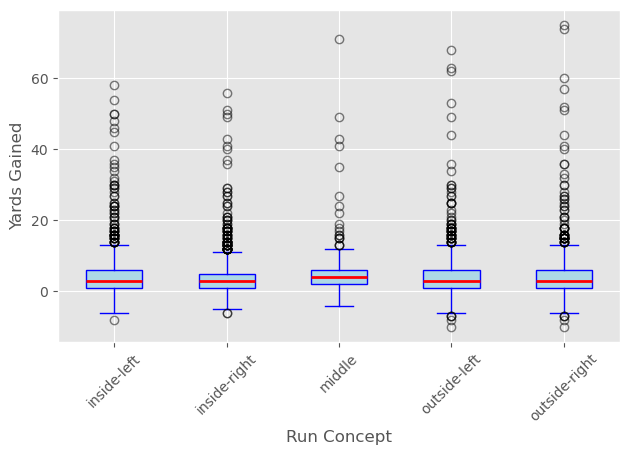

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
df.boxplot(
    column='yards_gained',
    by='play_dir_location',
    grid=False,
    showfliers=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    medianprops=dict(color='red', linewidth=2),
    flierprops=dict(marker='o', color='blue', alpha=0.5)
)
plt.title('')
plt.grid(True)
plt.suptitle('')  # Remove default groupby title
plt.xlabel('Run Concept')
plt.ylabel('Yards Gained')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
df.groupby('play_dir_location').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
play_dir_location,,
middle,5.099237,58.091603
outside-right,4.670455,57.139773
inside-left,4.662319,59.778986
outside-left,4.391039,58.401222
inside-right,4.369170,59.626877


In [30]:
df.groupby('down').agg({'yards_gained': 'mean', 'absolute_yardline_number':'mean'}).sort_values('yards_gained', ascending=False)

,yards_gained,absolute_yardline_number
down,,
1,4.656796,57.596861
2,4.440895,59.491374
3,4.349727,64.606557
4,3.542857,73.771429


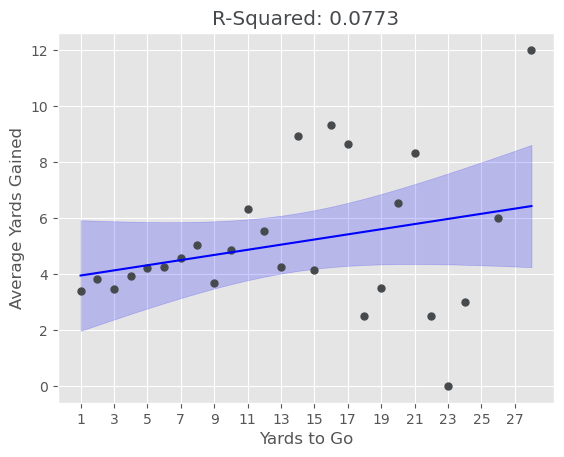

In [31]:
plt.style.use('ggplot')

avg = (
    df
    # .query('15 <= absolute_yardline_number <= 100') # filter between 5 and 90 yard lines
    .groupby('yards_to_go')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

# Linear regression for best fit line
X = sm.add_constant(avg['yards_to_go'])
ols_model = sm.OLS(avg['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

fig, ax = plt.subplots()
avg.plot(x='yards_to_go',y='yards_gained',linestyle='None', ax=ax, marker='o', color='#474a4d', markersize=5)
y_pred = est.predict(X)
x_pred = avg.yards_to_go.values
ax.plot(x_pred,y_pred, color='blue')

pred = est.get_prediction(X).summary_frame()

ax.fill_between(
    x_pred, 
    pred['mean_ci_lower'], 
    pred['mean_ci_upper'], 
    color='blue', 
    alpha=0.2
)

plt.xlabel('Yards to Go')
plt.ylabel('Average Yards Gained')
plt.title('R-Squared: {:.4f}'.format(est.rsquared), color='#474a4d')
plt.xticks(
    ticks=np.arange(
        df['yards_to_go'].min(),
        df['yards_to_go'].max() + 1,
        2
    ), 
    rotation=0
)

ax.get_legend().remove()
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

# Model Creation

In [32]:
df.head()

,game_play_id,run_concept,play_dir_location,motion_had_rush_attempt,pre_snap_motion_dist_traveled,motion_group,motion_present,motion_towards_playside,down,yards_to_go,absolute_yardline_number,offense_formation,defenders_in_box,pre_snap_score_diff,pre_snap_wp,yards_gained
0,2022091105_3712,OUTSIDE ZONE,inside-right,NaN,NaN,NaN,False,NaN,1,10,81,SINGLEBACK,6.0,-7,0.221582,14
1,2022091104_1094,OUTSIDE ZONE,outside-right,0.0,0.697350,Jet,True,1.0,1,10,35,SINGLEBACK,7.0,0,0.395236,1
2,2022091101_3923,INSIDE ZONE,middle,NaN,NaN,NaN,False,NaN,2,11,95,SINGLEBACK,8.0,-2,0.741719,0
3,2022091106_1380,INSIDE ZONE,inside-right,0.0,8.234742,Orbit,True,1.0,1,10,18,I_FORM,7.0,10,0.847051,1
4,2022091100_501,OUTSIDE ZONE,outside-left,0.0,9.052830,Orbit,True,1.0,1,10,33,SINGLEBACK,6.0,-3,0.618278,5


In [44]:
df.motion_group.unique()

array([nan, 'Jet', 'Orbit', 'Yo-Yo', 'Fly', 'Glide', 'Over'], dtype=object)

In [33]:
df.motion_group.unique()

array([nan, 'Jet', 'Orbit', 'Yo-Yo', 'Fly', 'Glide', 'Over'], dtype=object)

In [34]:
df.play_dir_location.unique()

array(['inside-right', 'outside-right', 'middle', 'outside-left',
       'inside-left'], dtype=object)

In [35]:
# filter between 5 and 90 yard lines
df = df.query('15 <= absolute_yardline_number <= 100').reset_index(drop=True)

In [36]:
avg_yards_gained_by_def_in_box = (
    df
    .groupby('defenders_in_box')
    .agg({'yards_gained': 'mean'})
    .reset_index()
)

X = sm.add_constant(avg_yards_gained_by_def_in_box['defenders_in_box'])
ols_model = sm.OLS(avg_yards_gained_by_def_in_box['yards_gained'], X)
est = ols_model.fit()
out = est.conf_int(alpha=0.05, cols=None)

# map predicitons ot defenders_in_box
avg_yards_gained_by_def_in_box['y_pred'] = est.predict(X)

df['avg_yards_gained_by_def_in_box'] = df['defenders_in_box'].map(avg_yards_gained_by_def_in_box.set_index('defenders_in_box')['y_pred'])

df['run_loc'] = np.where(
    df.play_dir_location.isin(['outside-right', 'outside-left']),
    'outside',
    np.where(
        df.play_dir_location.isin(['inside-right', 'inside-left']),
        'inside',
        'middle'
    )
)

In [53]:
X.motion_group_code.value_counts()

-1    2760
 0     634
 1     307
 5     268
 3     197
 4     148
 2     121
Name: motion_group_code, dtype: int64

In [64]:
df.head()

,game_play_id,run_concept,play_dir_location,motion_had_rush_attempt,pre_snap_motion_dist_traveled,motion_group,motion_present,motion_towards_playside,down,yards_to_go,absolute_yardline_number,offense_formation,defenders_in_box,pre_snap_score_diff,pre_snap_wp,yards_gained,avg_yards_gained_by_def_in_box,run_loc
0,2022091105_3712,OUTSIDE ZONE,inside-right,NaN,NaN,NaN,False,NaN,1,10,81,SINGLEBACK,6.0,-7,0.221582,14,4.711683,inside
1,2022091104_1094,OUTSIDE ZONE,outside-right,0.0,0.697350,Jet,True,1.0,1,10,35,SINGLEBACK,7.0,0,0.395236,1,3.784595,outside
2,2022091101_3923,INSIDE ZONE,middle,NaN,NaN,NaN,False,NaN,2,11,95,SINGLEBACK,8.0,-2,0.741719,0,2.857507,middle
3,2022091106_1380,INSIDE ZONE,inside-right,0.0,8.234742,Orbit,True,1.0,1,10,18,I_FORM,7.0,10,0.847051,1,3.784595,inside
4,2022091100_501,OUTSIDE ZONE,outside-left,0.0,9.052830,Orbit,True,1.0,1,10,33,SINGLEBACK,6.0,-3,0.618278,5,4.711683,outside


In [66]:
df.value_counts(['run_concept', 'motion_group']).reset_index().rename(columns={0:'count'}).sort_values(['run_concept', 'count'], ascending=[True, False])

,run_concept,motion_group,count
1,GAP,Jet,157
5,GAP,Over,96
7,GAP,Orbit,81
9,GAP,Fly,59
10,GAP,Glide,59
17,GAP,Yo-Yo,35
2,INSIDE ZONE,Jet,143
8,INSIDE ZONE,Orbit,68
15,INSIDE ZONE,Fly,40
18,INSIDE ZONE,Yo-Yo,34


In [65]:
df.motion_group.unique()

array([nan, 'Jet', 'Orbit', 'Yo-Yo', 'Fly', 'Glide', 'Over'], dtype=object)

In [67]:
df.run_concept.unique()

array(['OUTSIDE ZONE', 'INSIDE ZONE', 'GAP', 'MAN'], dtype=object)

In [69]:
import multiprocessing

n_cores = multiprocessing.cpu_count()

df = df.reset_index(drop=True)

# Define features
features = ['absolute_yardline_number', 'avg_yards_gained_by_def_in_box', 'motion_present', 
            'pre_snap_wp', 'yards_to_go', 'down', 'run_concept', 'run_loc', 'offense_formation',
            'motion_group', 'motion_had_rush_attempt', 'pre_snap_motion_dist_traveled', 'motion_towards_playside'] 
X = df[features].copy()
y = df[['yards_gained']].copy()

down_enc = pd.get_dummies(X['down'], prefix='down')
X = pd.concat([X, down_enc], axis=1)
X.drop(columns='down', inplace=True)

# ['OUTSIDE ZONE', 'INSIDE ZONE', 'GAP', 'MAN']
run_concept_enc = pd.get_dummies(X['run_concept'], prefix='run_concept')
X = pd.concat([X, run_concept_enc], axis=1)
X.drop(columns='run_concept', inplace=True)

run_loc_enc = pd.get_dummies(X['run_loc'], prefix='run_loc')
X = pd.concat([X, run_loc_enc], axis=1)
X.drop(columns='run_loc', inplace=True)

# ['SINGLEBACK', 'I_FORM', 'SHOTGUN', 'PISTOL', 'JUMBO']
offensive_formation_enc = pd.get_dummies(X['offense_formation'], prefix='offense_formation')
X = pd.concat([X, offensive_formation_enc], axis=1)
X.drop(columns='offense_formation', inplace=True)

# Create interaction terms between 'yards_to_go' and down variables
X['yards_to_go_down_1'] = X['yards_to_go'] * X['down_1']
X['yards_to_go_down_2'] = X['yards_to_go'] * X['down_2']
X['yards_to_go_down_3'] = X['yards_to_go'] * X['down_3']
X['yards_to_go_down_4'] = X['yards_to_go'] * X['down_4']

# Interaction between 'run_loc' and 'yards_to_go'
X['run_loc_outside_yards_to_go'] = X['run_loc_outside'] * X['yards_to_go']
X['run_loc_inside_yards_to_go'] = X['run_loc_inside'] * X['yards_to_go']
X['run_loc_middle_yards_to_go'] = X['run_loc_middle'] * X['yards_to_go']

# Motion groups: ['None', 'Jet', 'Orbit', 'Yo-Yo', 'Fly', 'Glide', 'Over']
X['motion_group'] = X['motion_group'].replace(np.nan, 'None')
motion_group_enc = pd.get_dummies(X['motion_group'], prefix='motion_group')
X = pd.concat([X, motion_group_enc], axis=1)

# Create Interaction terms between 'motion_group' and 'run_concept'
# Jet Motions
X['man_run_concept_with_jet_motion'] = X['run_concept_MAN'] * X['motion_group_Jet']
X['gap_run_concept_with_jet_motion'] = X['run_concept_GAP'] * X['motion_group_Jet']
X['outside_zone_run_concept_with_jet_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Jet']
X['inside_zone_run_concept_with_jet_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Jet']
# Orbit Motions
X['man_run_concept_with_orbit_motion'] = X['run_concept_MAN'] * X['motion_group_Orbit']
X['gap_run_concept_with_orbit_motion'] = X['run_concept_GAP'] * X['motion_group_Orbit']
X['outside_zone_run_concept_with_orbit_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Orbit']
X['inside_zone_run_concept_with_orbit_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Orbit']
# Yo-Yo Motions
X['man_run_concept_with_yo_yo_motion'] = X['run_concept_MAN'] * X['motion_group_Yo-Yo']
X['gap_run_concept_with_yo_yo_motion'] = X['run_concept_GAP'] * X['motion_group_Yo-Yo']
X['outside_zone_run_concept_with_yo_yo_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Yo-Yo']
X['inside_zone_run_concept_with_yo_yo_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Yo-Yo']
# Fly Motions
X['man_run_concept_with_fly_motion'] = X['run_concept_MAN'] * X['motion_group_Fly']
X['gap_run_concept_with_fly_motion'] = X['run_concept_GAP'] * X['motion_group_Fly']
X['outside_zone_run_concept_with_fly_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Fly']
X['inside_zone_run_concept_with_fly_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Fly']
# Glide Motions
X['man_run_concept_with_glide_motion'] = X['run_concept_MAN'] * X['motion_group_Glide']
X['gap_run_concept_with_glide_motion'] = X['run_concept_GAP'] * X['motion_group_Glide']
X['outside_zone_run_concept_with_glide_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Glide']
X['inside_zone_run_concept_with_glide_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Glide']
# Over Motions
X['man_run_concept_with_over_motion'] = X['run_concept_MAN'] * X['motion_group_Over']
X['gap_run_concept_with_over_motion'] = X['run_concept_GAP'] * X['motion_group_Over']
X['outside_zone_run_concept_with_over_motion'] = X['run_concept_OUTSIDE ZONE'] * X['motion_group_Over']
X['inside_zone_run_concept_with_over_motion'] = X['run_concept_INSIDE ZONE'] * X['motion_group_Over']
  
# Bayesian model
with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Absolute yardline number
    yardline_coeff = pm.Normal('yardline', mu=0, sigma=1)

    # Average yards gained by defenders in the box
    defenders_in_box_coeff = pm.Normal('avg_yards_gained_by_def_in_box', mu=0, sigma=1)

    # Pre snap win probability
    pre_snap_wp_coeff = pm.Normal('pre_snap_wp', mu=0, sigma=1)

    # Down coefficients
    down_1_coeff = pm.Normal('down_1', mu=0, sigma=1)
    down_2_coeff = pm.Normal('down_2', mu=0, sigma=1)
    down_3_coeff = pm.Normal('down_3', mu=0, sigma=1)
    down_4_coeff = pm.Normal('down_4', mu=0, sigma=1)

    # Yards to go for first down
    yards_to_go_coeff = pm.Normal('yards_to_go', mu=0, sigma=1)

    # Yards to go interaction with down
    yards_to_go_down_1_coeff = pm.Normal('yards_to_go_down_1', mu=0, sigma=1)
    yards_to_go_down_2_coeff = pm.Normal('yards_to_go_down_2', mu=0, sigma=1)
    yards_to_go_down_3_coeff = pm.Normal('yards_to_go_down_3', mu=0, sigma=1)
    yards_to_go_down_4_coeff = pm.Normal('yards_to_go_down_4', mu=0, sigma=1)

    # Run concepts
    man_run_concept_coeff = pm.Normal('run_concept_MAN', mu=0, sigma=1)
    gap_run_concept_coeff = pm.Normal('run_concept_GAP', mu=0, sigma=1)
    outside_zone_run_concept_coeff = pm.Normal('run_concept_OUTSIDE ZONE', mu=0, sigma=1)
    inside_zone_run_concept_coeff = pm.Normal('run_concept_INSIDE ZONE', mu=0, sigma=1)

    # Run location
    run_loc_outside = pm.Normal('run_loc_outside', mu=0, sigma=1)
    run_loc_inside = pm.Normal('run_loc_inside', mu=0, sigma=1)
    run_loc_middle = pm.Normal('run_loc_middle', mu=0, sigma=1)

    # Run location interaction with yards to go
    run_loc_outside_yards_to_go = pm.Normal('run_loc_outside_yards_to_go', mu=0, sigma=1)
    run_loc_inside_yards_to_go = pm.Normal('run_loc_inside_yards_to_go', mu=0, sigma=1)
    run_loc_middle_yards_to_go = pm.Normal('run_loc_middle_yards_to_go', mu=0, sigma=1)

    # Offensive formations
    off_formation_SINGLEBACK = pm.Normal('offense_formation_SINGLEBACK', mu=0, sigma=1)
    off_formation_I_FORM = pm.Normal('offense_formation_I_FORM', mu=0, sigma=1)
    off_formation_SHOTGUN = pm.Normal('offense_formation_SHOTGUN', mu=0, sigma=1)
    off_formation_PISTOL = pm.Normal('offense_formation_PISTOL', mu=0, sigma=1)
    off_formation_JUMBO = pm.Normal('offense_formation_JUMBO', mu=0, sigma=1)

    # Motion groups
    motion_group_Jet = pm.Normal('motion_group_Jet', mu=0, sigma=1)
    motion_group_Orbit = pm.Normal('motion_group_Orbit', mu=0, sigma=1)
    motion_group_Yo_Yo = pm.Normal('motion_group_Yo_Yo', mu=0, sigma=1)
    motion_group_Fly = pm.Normal('motion_group_Fly', mu=0, sigma=1)
    motion_group_Glide = pm.Normal('motion_group_Glide', mu=0, sigma=1)
    motion_group_Over = pm.Normal('motion_group_Over', mu=0, sigma=1)
    
    # Jet motion interaction with run concepts
    man_run_concept_with_jet_motion_coeff = pm.Normal('man_run_concept_with_jet_motion', mu=0, sigma=1)
    gap_run_concept_with_jet_motion_coeff = pm.Normal('gap_run_concept_with_jet_motion', mu=0, sigma=1)
    outside_zone_run_concept_with_jet_motion_coeff = pm.Normal('outside_zone_run_concept_with_jet_motion', mu=0, sigma=1)
    inside_zone_run_concept_with_jet_motion_coeff = pm.Normal('inside_zone_run_concept_with_jet_motion',mu=0, sigma=1)

    # Orbit motion interaction with run concepts
    man_run_concept_with_orbit_motion_coeff = pm.Normal('man_run_concept_with_orbit_motion',mu=0, sigma=1)
    gap_run_concept_with_orbit_motion_coeff = pm.Normal('gap_run_concept_with_orbit_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_orbit_motion_coeff = pm.Normal('outside_zone_run_concept_with_orbit_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_orbit_motion_coeff = pm.Normal('inside_zone_run_concept_with_orbit_motion',mu=0, sigma=1)

    # Yo-Yo motion interaction with run concepts
    man_run_concept_with_yo_yo_motion_coeff = pm.Normal('man_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    gap_run_concept_with_yo_yo_motion_coeff = pm.Normal('gap_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_yo_yo_motion_coeff = pm.Normal('outside_zone_run_concept_with_yo_yo_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_yo_yo_motion_coeff = pm.Normal('inside_zone_run_concept_with_yo_yo_motion',mu=0, sigma=1)

    # Fly motion interaction with run concepts
    man_run_concept_with_fly_motion_coeff = pm.Normal('man_run_concept_with_fly_motion',mu=0, sigma=1)
    gap_run_concept_with_fly_motion_coeff = pm.Normal('gap_run_concept_with_fly_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_fly_motion_coeff = pm.Normal('outside_zone_run_concept_with_fly_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_fly_motion_coeff = pm.Normal('inside_zone_run_concept_with_fly_motion',mu=0, sigma=1)

    # Glide motion interaction with run concepts
    man_run_concept_with_glide_motion_coeff = pm.Normal('man_run_concept_with_glide_motion',mu=0, sigma=1)
    gap_run_concept_with_glide_motion_coeff = pm.Normal('gap_run_concept_with_glide_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_glide_motion_coeff = pm.Normal('outside_zone_run_concept_with_glide_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_glide_motion_coeff = pm.Normal('inside_zone_run_concept_with_glide_motion',mu=0, sigma=1)

    # Over motion interaction with run concepts
    man_run_concept_with_over_motion_coeff = pm.Normal('man_run_concept_with_over_motion',mu=0, sigma=1)
    gap_run_concept_with_over_motion_coeff = pm.Normal('gap_run_concept_with_over_motion',mu=0, sigma=1)
    outside_zone_run_concept_with_over_motion_coeff = pm.Normal('outside_zone_run_concept_with_over_motion',mu=0, sigma=1)
    inside_zone_run_concept_with_over_motion_coeff = pm.Normal('inside_zone_run_concept_with_over_motion',mu=0, sigma=1)
       
    mu = (
        intercept + 
        yardline_coeff * X['absolute_yardline_number'] +
        defenders_in_box_coeff * X['avg_yards_gained_by_def_in_box'] +
        pre_snap_wp_coeff * X['pre_snap_wp'] +

        # Down coefficients
        down_1_coeff * X['down_1'] +
        down_2_coeff * X['down_2'] +
        down_3_coeff * X['down_3'] +
        down_4_coeff * X['down_4'] +

        # Yards to go for first down
        yards_to_go_coeff * X['yards_to_go'] +

        # Yards to go interaction with down
        yards_to_go_down_1_coeff * X['yards_to_go_down_1'] +
        yards_to_go_down_2_coeff * X['yards_to_go_down_2'] +
        yards_to_go_down_3_coeff * X['yards_to_go_down_3'] +
        yards_to_go_down_4_coeff * X['yards_to_go_down_4'] +

        # Run concepts
        man_run_concept_coeff * X['run_concept_MAN'] +
        gap_run_concept_coeff * X['run_concept_GAP'] +
        outside_zone_run_concept_coeff * X['run_concept_OUTSIDE ZONE'] +
        inside_zone_run_concept_coeff * X['run_concept_INSIDE ZONE'] +

        # Run location
        run_loc_outside * X['run_loc_outside'] +
        run_loc_inside * X['run_loc_inside'] +
        run_loc_middle * X['run_loc_middle'] +

        # run location interaction with yards to go
        run_loc_outside_yards_to_go * X['run_loc_outside_yards_to_go'] +
        run_loc_inside_yards_to_go * X['run_loc_inside_yards_to_go'] +
        run_loc_middle_yards_to_go * X['run_loc_middle_yards_to_go'] +

        # Offensive formations
        off_formation_SINGLEBACK * X['offense_formation_SINGLEBACK'] +
        off_formation_I_FORM * X['offense_formation_I_FORM'] +
        off_formation_SHOTGUN * X['offense_formation_SHOTGUN'] +
        off_formation_PISTOL * X['offense_formation_PISTOL'] +
        off_formation_JUMBO * X['offense_formation_JUMBO'] +

        # Motion groups
        motion_group_Jet * X['motion_group_Jet'] +
        motion_group_Orbit * X['motion_group_Orbit'] +
        motion_group_Yo_Yo * X['motion_group_Yo-Yo'] +
        motion_group_Fly * X['motion_group_Fly'] +
        motion_group_Glide * X['motion_group_Glide'] +
        motion_group_Over * X['motion_group_Over'] +

        # Jet motion interaction with run concepts
        man_run_concept_with_jet_motion_coeff * X['man_run_concept_with_jet_motion'] +
        gap_run_concept_with_jet_motion_coeff * X['gap_run_concept_with_jet_motion'] +
        outside_zone_run_concept_with_jet_motion_coeff * X['outside_zone_run_concept_with_jet_motion'] +
        inside_zone_run_concept_with_jet_motion_coeff * X['inside_zone_run_concept_with_jet_motion'] +

        # Orbit motion interaction with run concepts
        man_run_concept_with_orbit_motion_coeff * X['man_run_concept_with_orbit_motion'] +
        gap_run_concept_with_orbit_motion_coeff * X['gap_run_concept_with_orbit_motion'] +
        outside_zone_run_concept_with_orbit_motion_coeff * X['outside_zone_run_concept_with_orbit_motion'] +
        inside_zone_run_concept_with_orbit_motion_coeff * X['inside_zone_run_concept_with_orbit_motion'] +

        # Yo-Yo motion interaction with run concepts
        man_run_concept_with_yo_yo_motion_coeff * X['man_run_concept_with_yo_yo_motion'] +
        gap_run_concept_with_yo_yo_motion_coeff * X['gap_run_concept_with_yo_yo_motion'] +
        outside_zone_run_concept_with_yo_yo_motion_coeff * X['outside_zone_run_concept_with_yo_yo_motion'] +
        inside_zone_run_concept_with_yo_yo_motion_coeff * X['inside_zone_run_concept_with_yo_yo_motion'] +

        # Fly motion interaction with run concepts
        man_run_concept_with_fly_motion_coeff * X['man_run_concept_with_fly_motion'] +
        gap_run_concept_with_fly_motion_coeff * X['gap_run_concept_with_fly_motion'] +
        outside_zone_run_concept_with_fly_motion_coeff * X['outside_zone_run_concept_with_fly_motion'] +
        inside_zone_run_concept_with_fly_motion_coeff * X['inside_zone_run_concept_with_fly_motion'] +

        # Glide motion interaction with run concepts
        man_run_concept_with_glide_motion_coeff * X['man_run_concept_with_glide_motion'] +
        gap_run_concept_with_glide_motion_coeff * X['gap_run_concept_with_glide_motion'] +
        outside_zone_run_concept_with_glide_motion_coeff * X['outside_zone_run_concept_with_glide_motion'] +
        inside_zone_run_concept_with_glide_motion_coeff * X['inside_zone_run_concept_with_glide_motion'] +

        # Over motion interaction with run concepts
        man_run_concept_with_over_motion_coeff * X['man_run_concept_with_over_motion'] +
        gap_run_concept_with_over_motion_coeff * X['gap_run_concept_with_over_motion'] +
        outside_zone_run_concept_with_over_motion_coeff * X['outside_zone_run_concept_with_over_motion'] +
        inside_zone_run_concept_with_over_motion_coeff * X['inside_zone_run_concept_with_over_motion']
    )

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    yp = pm.Normal('yards_gained', mu=mu, sigma=sigma, observed=y['yards_gained'])

    # Sample
    trace = pm.sample_smc(
        draws=2000,  # Number of posterior samples
        return_inferencedata=True,  # Return results as an ArviZ InferenceData object
        idata_kwargs={'log_likelihood': True},  # Include log likelihood
        chains=4,  # Number of independent chains
        cores=n_cores,  # Number of CPU cores to use
        parallel=True,  # Enable parallel computation
        progressbar=True  # Show progress bar during sampling
    )

# Summarize results
az.summary(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.509,0.794,0.033,3.002,0.009,0.006,7775.0,7767.0,1.0
yardline,-0.012,0.005,-0.021,-0.004,0.000,0.000,6939.0,7537.0,1.0
avg_yards_gained_by_def_in_box,0.328,0.137,0.071,0.589,0.002,0.001,8024.0,8032.0,1.0
pre_snap_wp,-0.360,0.336,-1.001,0.265,0.004,0.003,7689.0,7930.0,1.0
down_1,0.286,0.800,-1.194,1.835,0.009,0.007,7591.0,7055.0,1.0
down_2,0.700,0.626,-0.449,1.911,0.007,0.005,7831.0,7426.0,1.0
down_3,0.222,0.647,-1.047,1.371,0.007,0.005,7884.0,8077.0,1.0
down_4,0.318,0.859,-1.268,1.944,0.010,0.007,7617.0,7625.0,1.0
yards_to_go,0.113,0.611,-1.095,1.208,0.007,0.005,7980.0,7673.0,1.0
yards_to_go_down_1,-0.004,0.491,-0.904,0.930,0.006,0.004,7876.0,7280.0,1.0


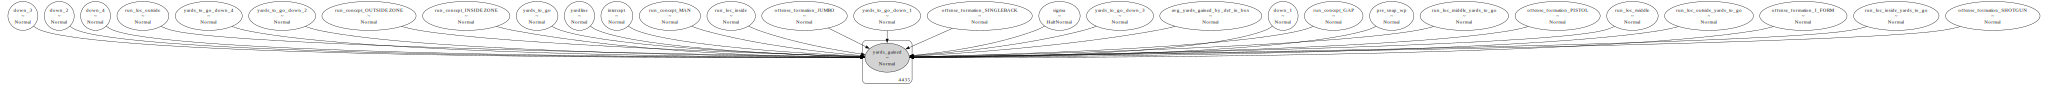

In [62]:
pm.model_to_graphviz(model)

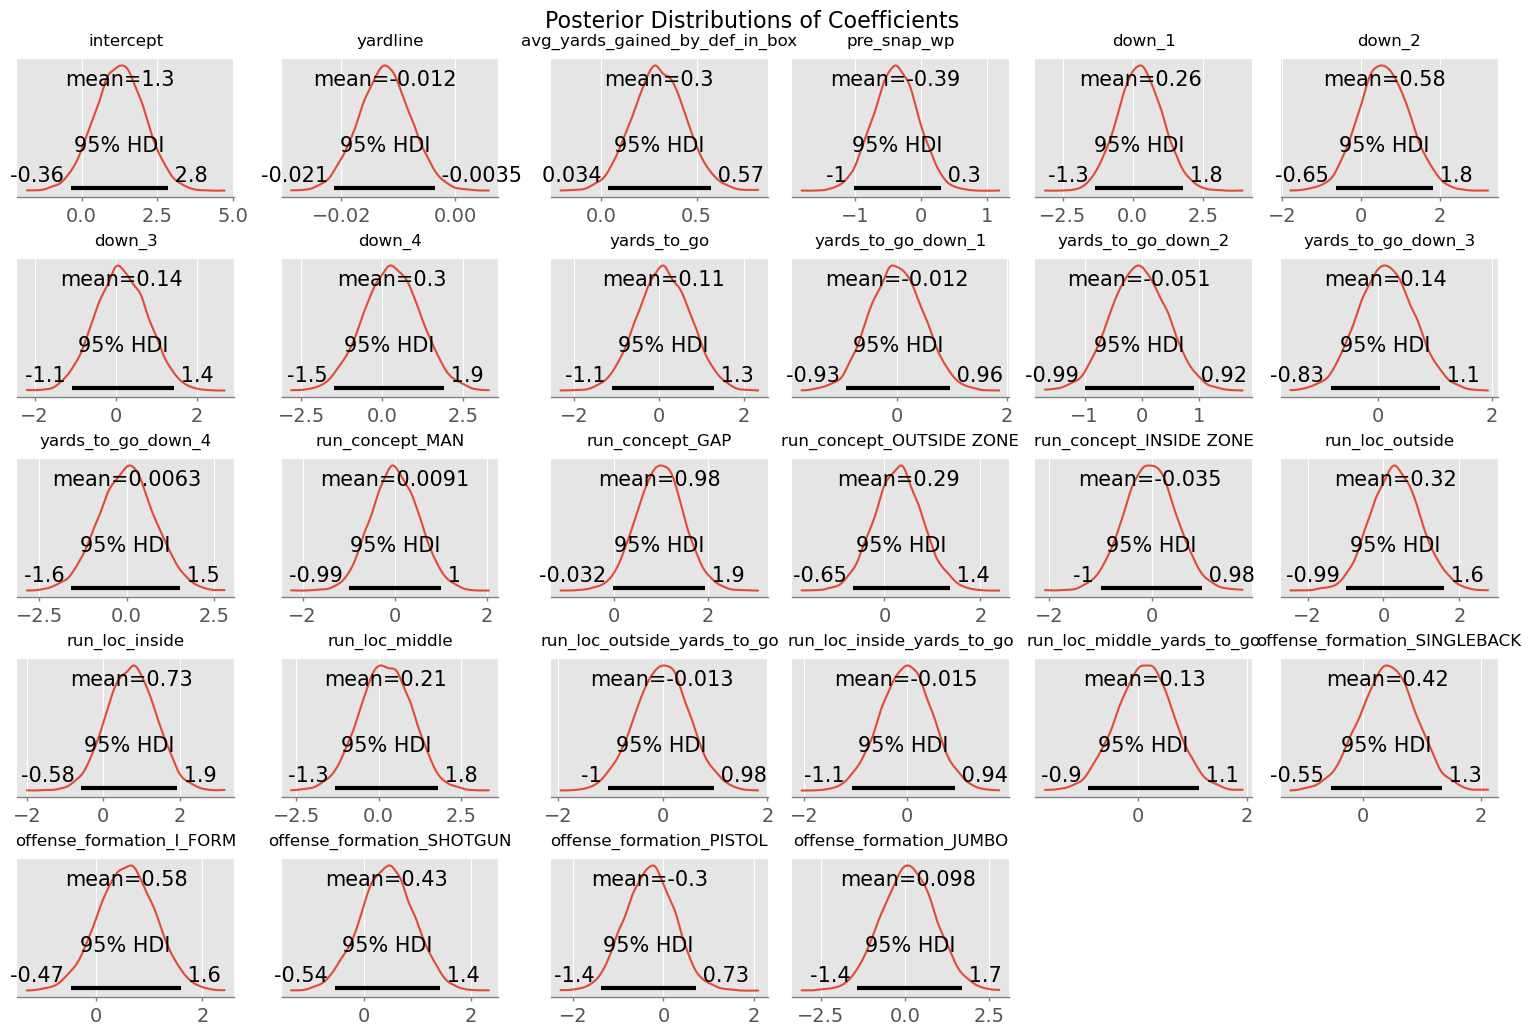

In [49]:
import arviz as az
import matplotlib.pyplot as plt
import math

# Visualize the distributions of each coefficient
coefficients = ['intercept', 'yardline', 'avg_yards_gained_by_def_in_box', 'pre_snap_wp',
                'down_1', 'down_2', 'down_3', 'down_4',
                'yards_to_go', 'yards_to_go_down_1', 'yards_to_go_down_2', 'yards_to_go_down_3', 'yards_to_go_down_4',
                'run_concept_MAN', 'run_concept_GAP', 'run_concept_OUTSIDE ZONE', 'run_concept_INSIDE ZONE',
                'run_loc_outside', 'run_loc_inside', 'run_loc_middle',
                'run_loc_outside_yards_to_go', 'run_loc_inside_yards_to_go', 'run_loc_middle_yards_to_go',
                'offense_formation_SINGLEBACK', 'offense_formation_I_FORM', 'offense_formation_SHOTGUN',
                'offense_formation_PISTOL', 'offense_formation_JUMBO']
posterior_samples = trace.posterior

# Create subplots for each coefficient
n_rows = 5
n_cols = math.ceil(len(coefficients) / n_rows)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), constrained_layout=True)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each coefficient
for ax, coeff in zip(axes, coefficients):
    # Plot the posterior distribution
    az.plot_posterior(posterior_samples[coeff], ax=ax, hdi_prob=0.95)
    
    # Set the title to the coefficient name
    ax.set_title(coeff, fontsize=12, pad=10)

# Hide any unused subplots
for ax in axes[len(coefficients):]:
    ax.axis('off')

# Display the plots
plt.suptitle('Posterior Distributions of Coefficients', fontsize=16, y=1.02)
plt.show()

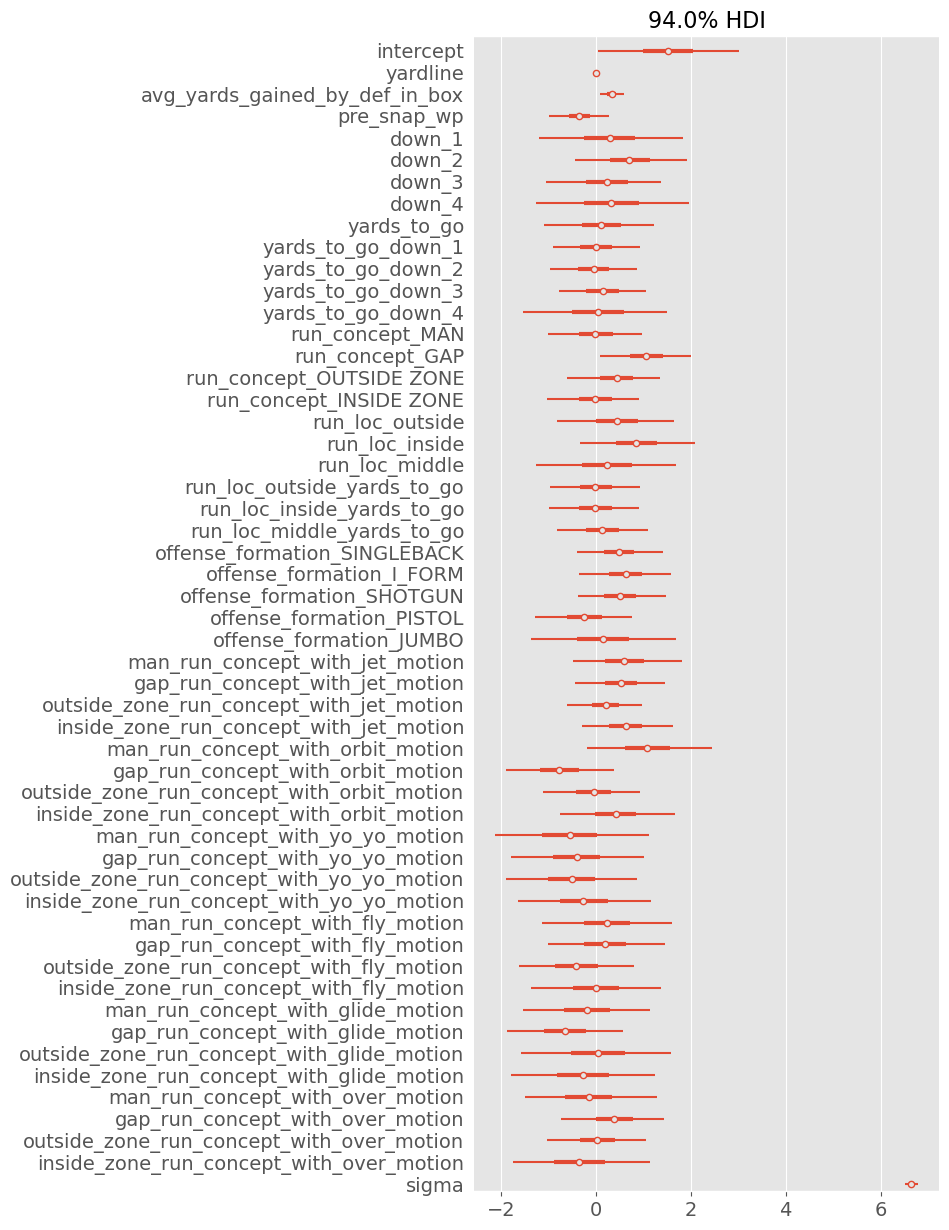

In [73]:
az.plot_forest(trace, figsize=(6, 15), combined=True)
plt.show()

In [70]:
with model:
    y_pred_trace = pm.sample_posterior_predictive(trace)

y_pred = y_pred_trace.posterior_predictive["yards_gained"].mean(axis=0).mean(axis=0).values
y_obs = y["yards_gained"].values

r_squared = 1 - (np.var(y_obs - y_pred) / np.var(y_obs))
print(f"Bayesian R^2: {r_squared:.5f}")

Sampling: [yards_gained]


Output()

Bayesian R^2: 0.01531
